# Code for stabilising the Morris-Lecar (finding the Ihold and Iscale)

## libraries

In [284]:
from brian2 import *
import scipy.io as sio
%matplotlib inline

start_scope()

### creating timed array with current

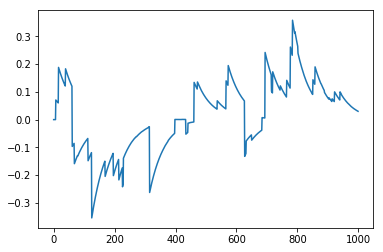

In [285]:
input_I = sio.loadmat('INPUT_THEORY_new.mat')
INPUT = input_I['THEORY']
TimedA=[]
for x in nditer(INPUT):
    TimedA.append(x)

#check
plot(TimedA[0:1000])

### constants 

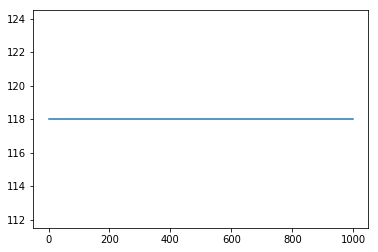

In [286]:
#constants for main model
g_L = 2*mS
g_Ca = 4*mS
g_K = 8*mS
V_L = -50*mV
V_Ca = 100*mV
V_K = -70*mV
lambda_m__max = 0.1*kHz
lambda_n__max = 1.0/(15*ms)
V_1 = 10*mV
V_2 = 15*mV  # Note that Figure caption says -15 which seems to be a typo
V_3 = 6*mV
V_4 = 14.5*mV
C = 20*uF

#constants of scaling the input
Ihold=118
Iscale=0

#new stimulus with scaling
for i,x in enumerate(TimedA):
    x=Ihold+Iscale*x
    TimedA[i]=x
    
#checking to see if values were added right
plot(TimedA[0:1000])

#making the stimulus
stimulus=TimedArray(TimedA*uamp,dt=0.1*ms)

#MAIN CONSTANT OF MODEL
Bw=0*mV

### model equations

In [287]:
eqs = '''
dV/dt = (-g_L*(V - V_L) - g_Ca*m_inf*(V - V_Ca) - g_K*n*(V - V_K) + stimulus(t))/C : volt
dm/dt = lambda_m*(m_inf - m) : 1
dn/dt = lambda_n*(n_inf - n) : 1
m_inf = 0.5*(1 + tanh((V - V_1)/V_2)) : 1
n_inf = 0.5*(1 + tanh((V - V_3)/V_4)) : 1
lambda_m = lambda_m__max*cosh((V - V_1)/(2*V_2)) : Hz
lambda_n = lambda_n__max*cosh((V - V_3)/(2*V_4)) : Hz
'''

### neuron statement

In [288]:
G=NeuronGroup(1,eqs,dt=0.1*ms,method='euler',events={'custom_event1': 'm>1','custom_event2': 'm<0','custom_event3': 'n>1','custom_event4': 'n<0'})
initial_values = {'V': -70*mV, 'm': 0.,'n':0.}
G.set_states(initial_values)
G.run_on_event('custom_event1','m=1')
G.run_on_event('custom_event2','m=0')
G.run_on_event('custom_event3','n=1')
G.run_on_event('custom_event4','n=0')

Resetter(clock=Clock(dt=100. * usecond, name='neurongroup_2_clock_15'), when=after_resets, order=0, name='neurongroup_2_resetter_18')

### monitor statement

In [289]:
VOLT = StateMonitor(G, 'V', record=True,dt=0.1*ms)
M = StateMonitor(G,'m',record=True,dt=0.1*ms)
N = StateMonitor(G,'n',record=True,dt=0.1*ms)

## Running the simulation

In [290]:
run(1000*ms,report='stdout',report_period=60*second)

WARNING    /home/tzikos/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/tzikos/.cython/brian_extensions/_cython_magic_55e5ef3e2b14c0e61fb98294b499b333.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]


Starting simulation at t=0. s for a duration of 1. s
1.0 (100%) simulated in 1s


### calculate number of spikes

In [291]:
spikes=0
#iterate in list of M.V[0] with three iterators to find the spikes
for i,x in enumerate(VOLT.V[0]):
    if (i>=1) and (i<9999):
        if VOLT.V[0][i-1]<VOLT.V[0][i] and VOLT.V[0][i+1]<VOLT.V[0][i] and VOLT.V[0][i]>=10*mV:
            spikes+=1
print('The firing rate is :',spikes)

The firing rate is : 2


### plot

Text(0,0.5,'values')

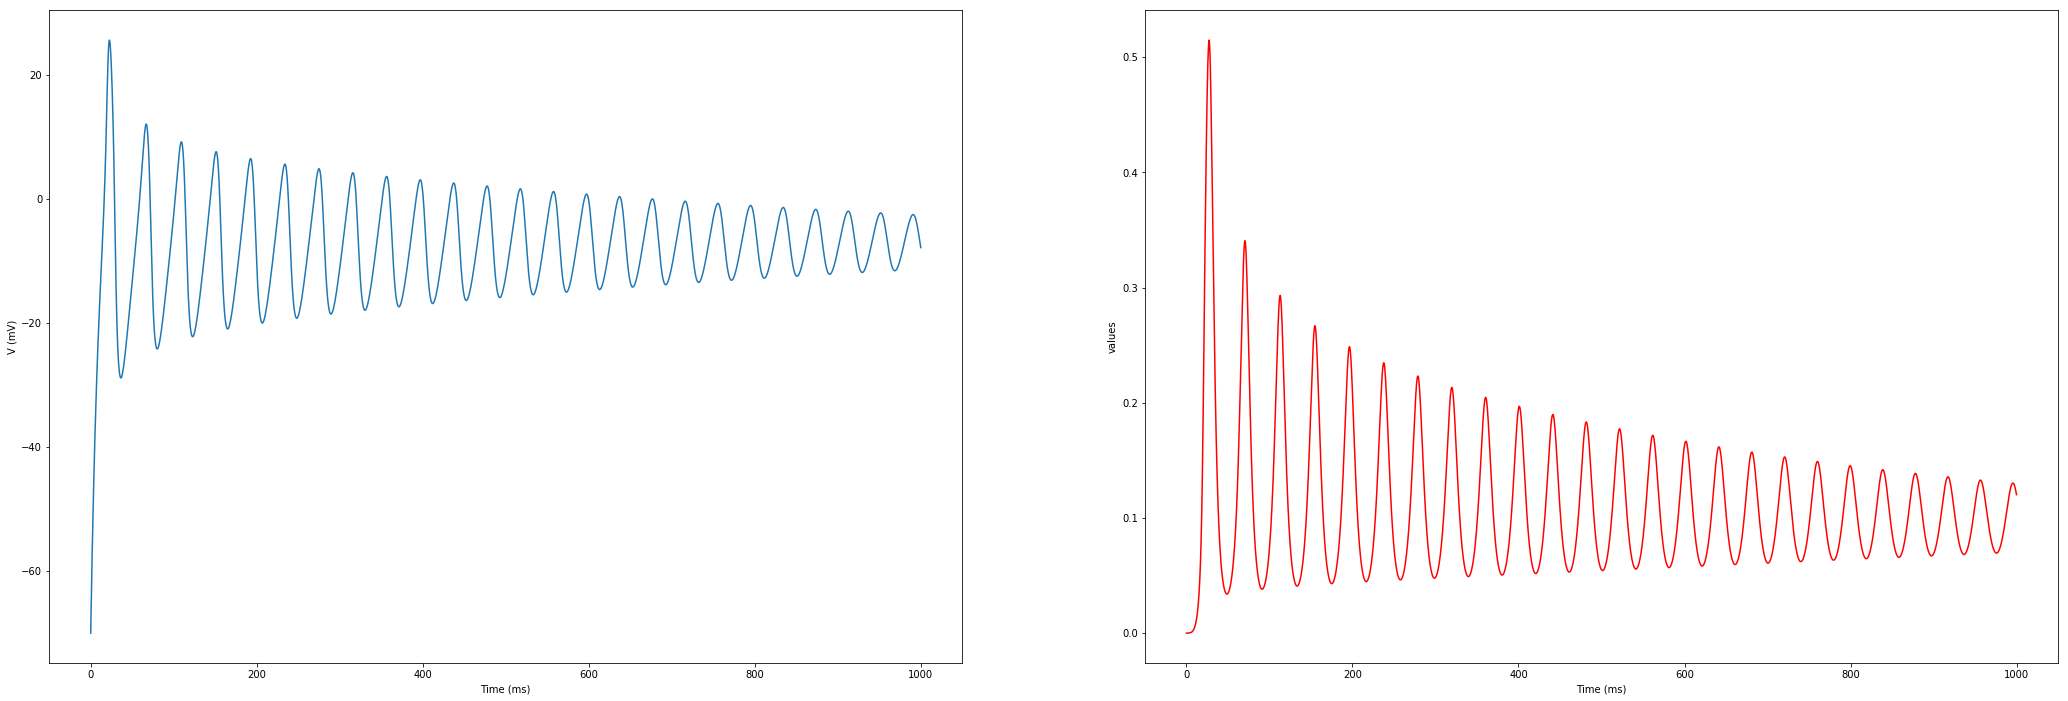

In [292]:
#plotting
figure(figsize=(36,12))
subplot(121)
plot(VOLT.t/ms, VOLT.V[0]/mV)
xlabel('Time (ms)')
ylabel('V (mV)')
subplot(122)
plot(VOLT.t/ms, M.m[0],'r',N.n[0],'b')
xlabel('Time (ms)')
ylabel('values')

# problems

changing bw doesnt change the neuron's behavior

### interesting  behavior

Ihold=36.74 for bw=0mV <br>
Ihold=42.089364 for bw=-13mV <br>
Ihold=78.1000 for bw=-21mV <br>


Ihold=500 bw=-21mV gslow=32

gslow, bm decreasing, gfast increasing -> increases class 1

# for stable Iscale
Iscale=310
Ihold=-1.1

# for stable rate
Iscale=334 for b=0 <br>
Iscale=342 for b=-4 <br>
Iscale=352 for b=-8 <br>
Iscale=374 for b=-13 <br>
Iscale=405 for b=-17 <br>
Iscale=450 for b=-21 <br>